<table>
 <tr align=left><td><img align=left src="https://i.creativecommons.org/l/by/4.0/88x31.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

Material heavily borrowed from David I. Ketcheson's [HyperPython](https://github.com/ketch/HyperPython) under a similar license as the one above.  Mistakes introduced are the responsibility of Kyle Mandli so complain to him.

If you are interested in the animation tools used there is a tutorial on their use at 

https://nbviewer.jupyter.org/url/www.clawpack.org/_static/notebooks/animation_tools_demo.ipynb

In [1]:
%matplotlib inline

from __future__ import print_function
import numpy
import matplotlib.pyplot as plt

# Note that this module is found in the base directory
import utils.animation as animation

# Finite Volume Methods

## Conservation/Balance Laws

Before we specifically discuss finite volume methods we will explore the class of PDEs that are *(hyperbolic) conservation laws*.  These equations generally describe the movement of some physical quantity that should be conserved.  Examples of these quantities include mass, momentum, or energy.

### Euler Equations

$$\left \{ \begin{aligned}
    &\frac{\partial \rho}{\partial t} + \frac{\partial}{\partial x} \left( \rho u \right ) = 0 \\
    &\frac{\partial}{\partial t} \left(\rho u\right) + \frac{\partial}{\partial x} \left( \rho u^2 + p \right ) = 0 \\
    &\frac{\partial E}{\partial t} + \frac{\partial}{\partial x} \left[u (E + p) \right ] = 0
\end{aligned} \right .$$

### Shallow Water Equations
$$\left \{ \begin{aligned}
    &\frac{\partial h}{\partial t} + \frac{\partial}{\partial x} \left( h u \right ) = 0 \\
    &\frac{\partial}{\partial t} \left(h u\right) + \frac{\partial}{\partial x} \left( h u^2 + \frac{1}{2} g h^2 \right ) = - g h \frac{\partial b}{\partial x}
\end{aligned} \right .$$

### Incompressible Navier-Stokes
$$\left \{ \begin{aligned}
    &\nabla \cdot u = 0 \\
    &\frac{\partial u}{\partial t} + u \cdot \nabla u = - \frac{1}{\rho} \nabla p + \nu \nabla^2 u
\end{aligned} \right .$$


### Conservation of Mass

Imagine a fluid flowing in a narrow tube.  We'll use $q$ to indicate the density of the fluid and $u$ to indicate its velocity.  Both of these are functions of space and time: $q = q(x,t)$; $u=u(x,t)$.  The total mass in the section of tube $[x_1,x_2]$ is

\begin{equation}
\int_{x_1}^{x_2} q(x,t) dx.
\end{equation}

This total mass can change in time due to fluid flowing in or out of this section of the tube.  We call the rate of flow the *flux*, and represent it with the function $f(q)$.  Thus the net rate of flow of mass into (or out of) the interval $[x_1,x_2]$ at time $t$ is

$$f(q(x_1,t)) - f(q(x_2,t)).$$

We just said that this rate of flow must equal the time rate of change of total mass; i.e.
$$
    \frac{d}{dt} \int_{x_1}^{x_2} q(x,t) dx = f(q(x_1,t)) - f(q(x_2,t)).
$$

Assuming the functions are continuous (enough) we can write 
$$
    \int_{x_1}^{x_2} \frac{\partial}{\partial x} f(q) dx = f(q(x_2,t)) - f(q(x_1,t))
$$ 
and therefore rewrite out conservation law as
$$
    \frac{d}{dt} \int_{x_1}^{x_2} q(x,t) dx = -\int_{x_1}^{x_2} \frac{\partial}{\partial x} f(q) dx.
$$

Under certain smoothness assumptions on $q$, we can move the time derivative inside the integral.  We'll also put everything on the left side, to obtain
$$
    \int_{x_1}^{x_2} \left(\frac{\partial}{\partial t}q(x,t) + \frac{\partial}{\partial x} f(q)\right) dx = 0.
$$

Since this integral is zero for *any* choice of $x_1,x_2$, it must be that the integrand (the expression in parentheses) is actually zero *everywhere*!  Therefore we can write the **differential conservation law**
$$
    q(x,t)_t + f(q(x,t))_x = 0.
$$

This equation expresses the fact that the total mass is conserved -- since locally the mass can change only due to a net inflow or outflow.

### Advection 

In order to solve the conservation law above, we need an expression for the flux, $f$.  The rate of flow is just mass times velocity: $f=u q$.  Thus we obtain the **continuity equation**
$$
    q_t + (uq)_x = 0.
$$

In general, we need another equation to determine the velocity $u(x,t)$.  Later we will look at the full equations of fluid dynamics, but for now let's consider the simplest case, in which all of the fluid flows at a single, constant velocity $u(x,t)=a$.  Then the continuity equation becomes the *advection equation*

$$q_t + a q_x = 0.$$

We already saw that the solution to the advection equation is $$q(x,t) = q_0(x-at).$$  Let's plot the solution of the advection equation on the interval $[0,1]$ for the initial condition $$q_0(x) = e^{-2(x-1/2)^2}.$$  


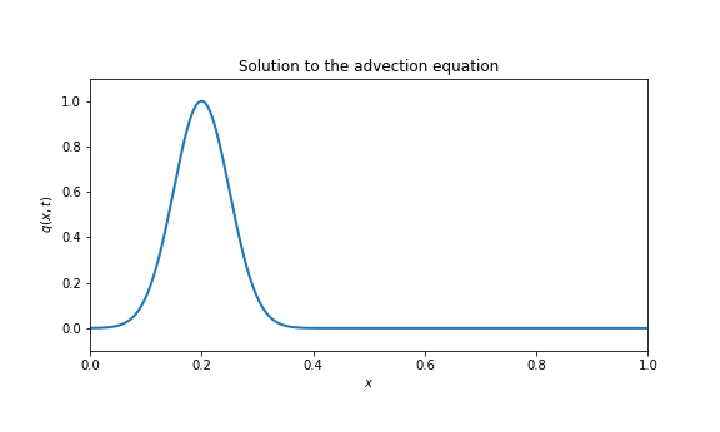
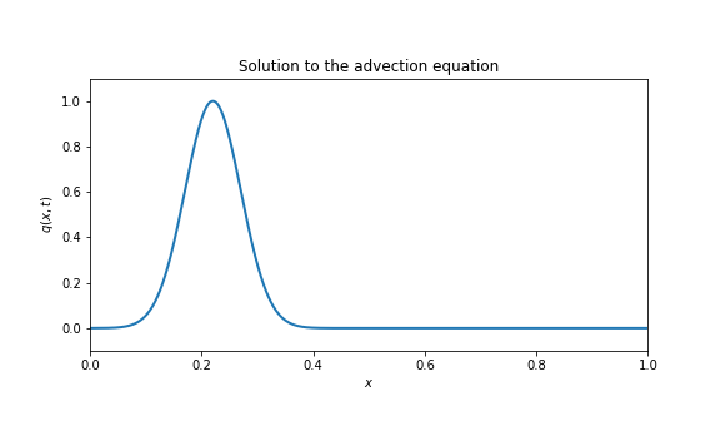
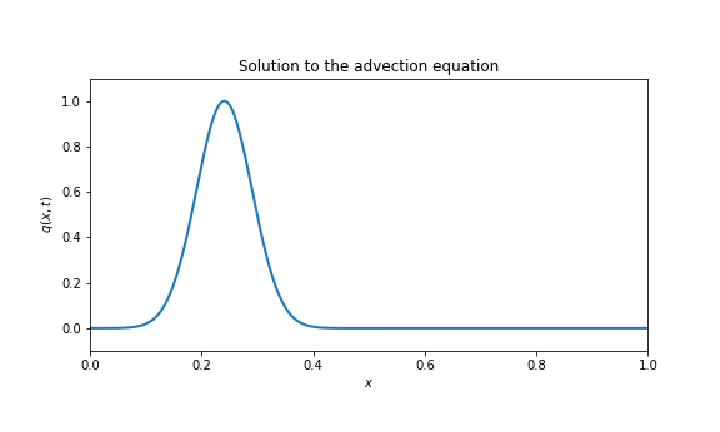
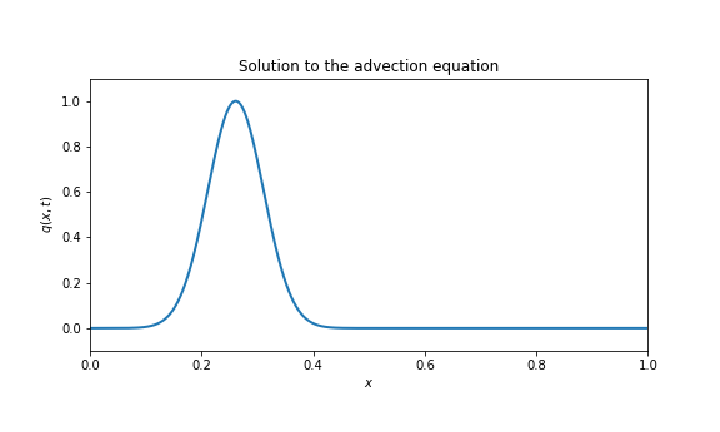
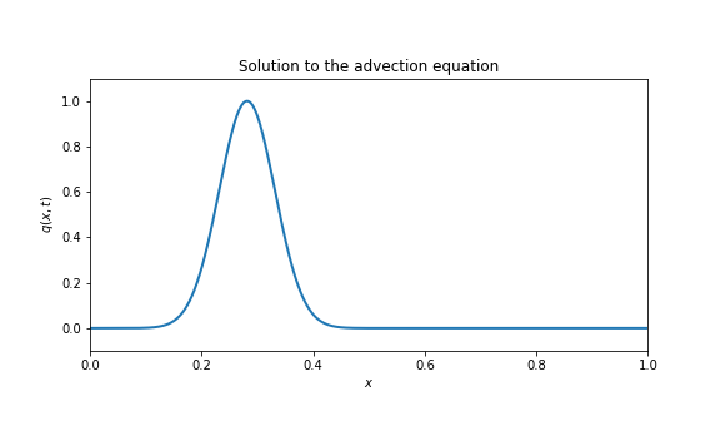
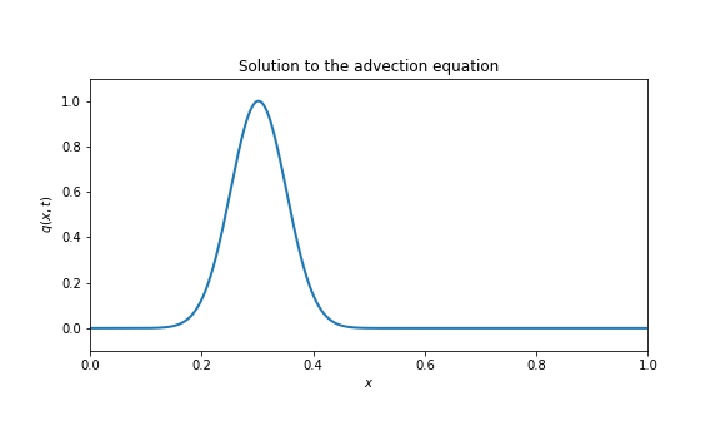
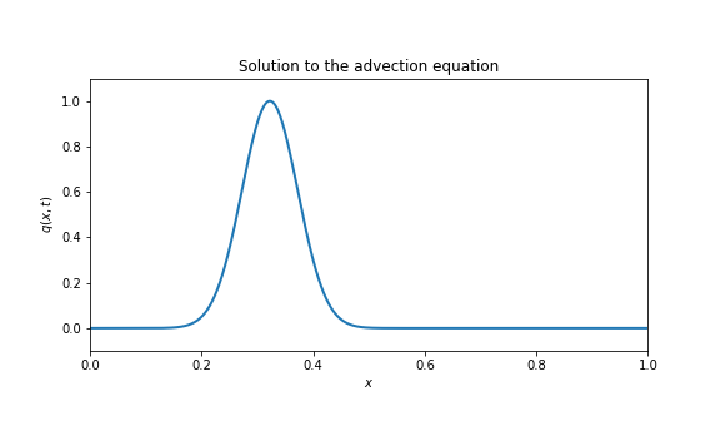
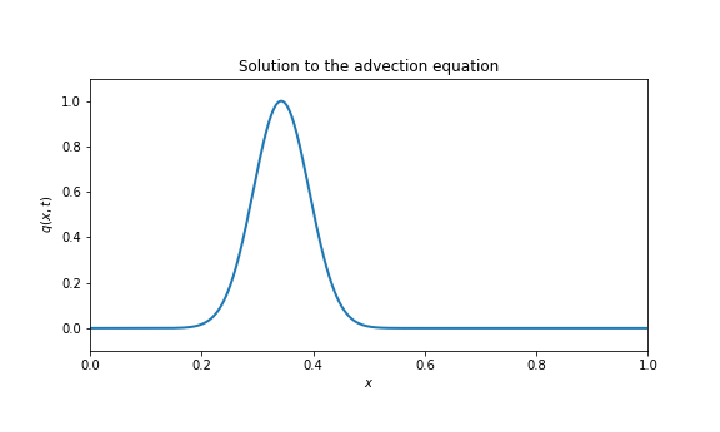
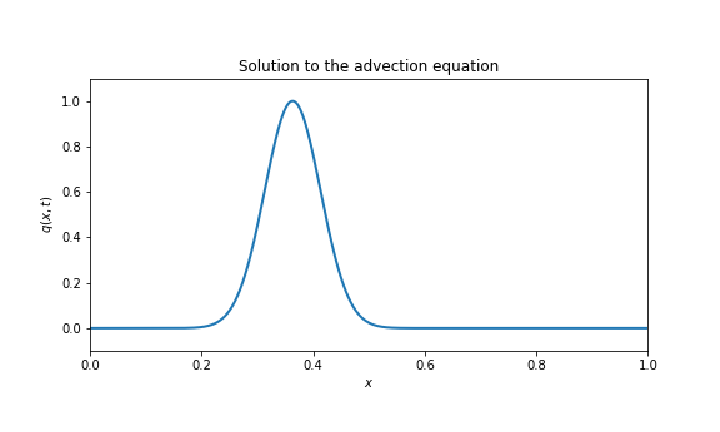
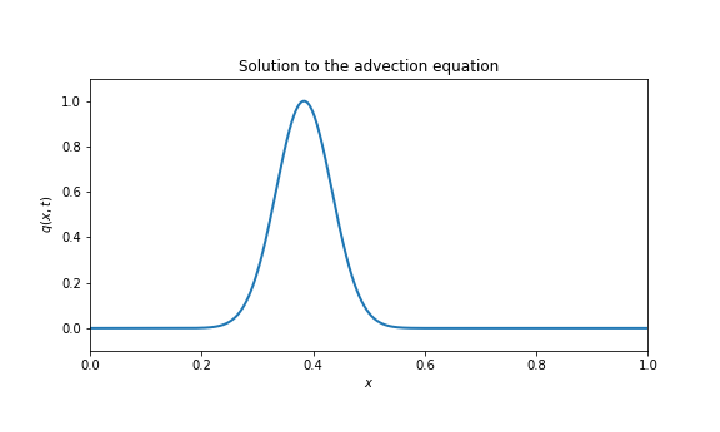
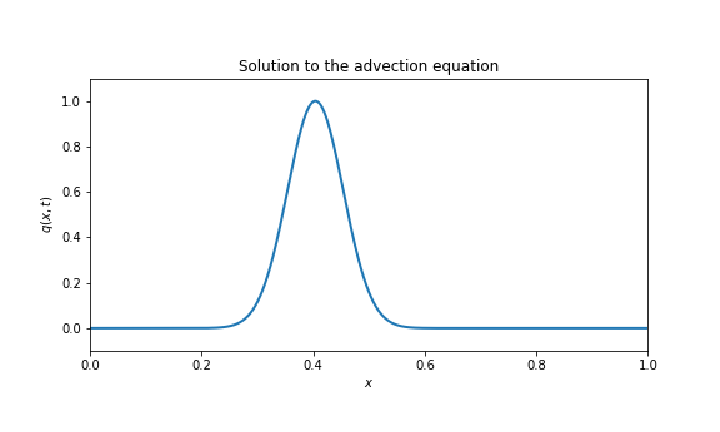
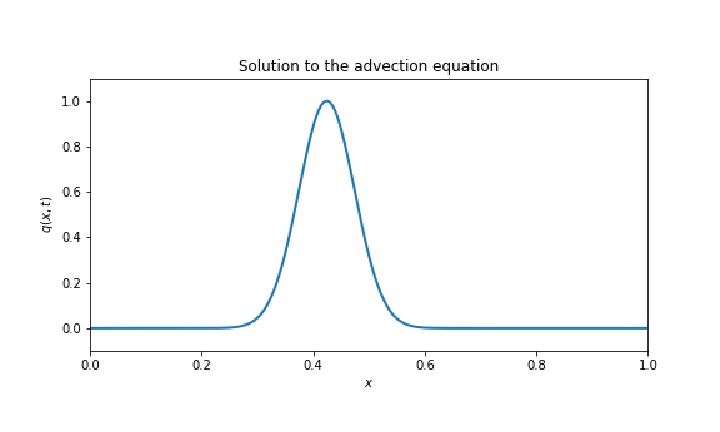
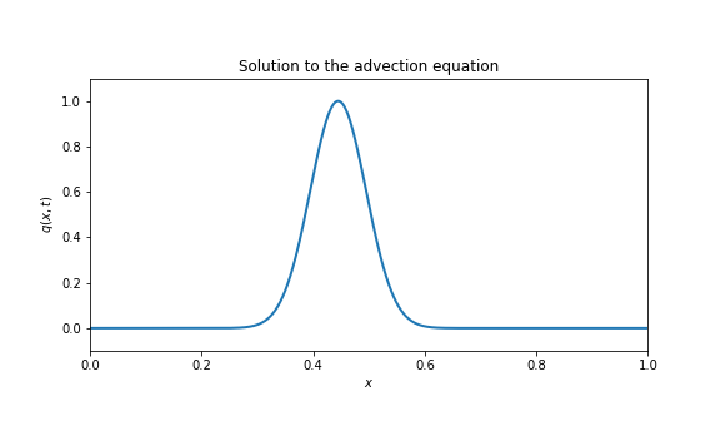
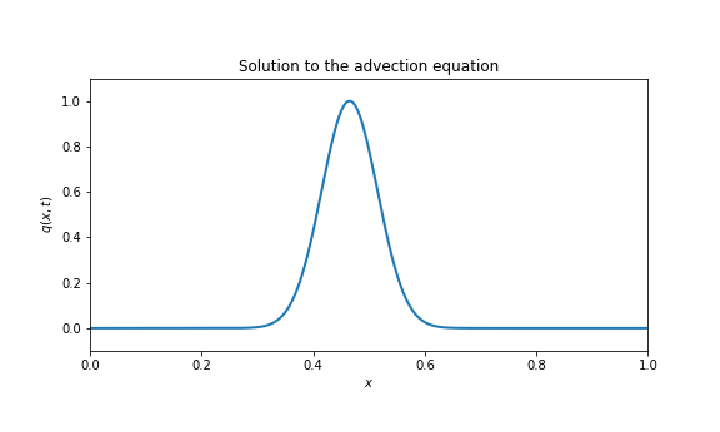
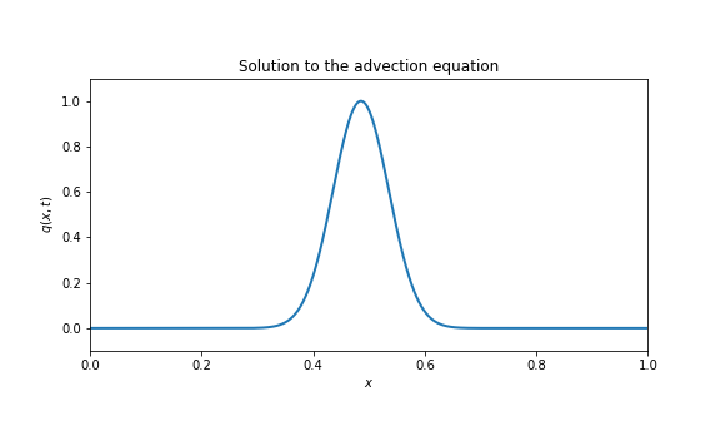
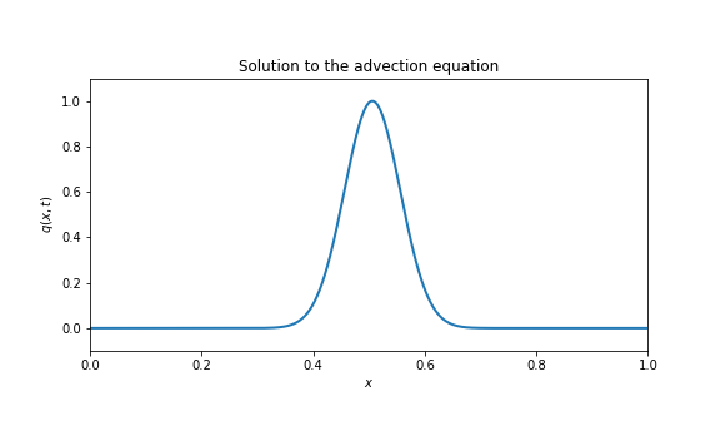
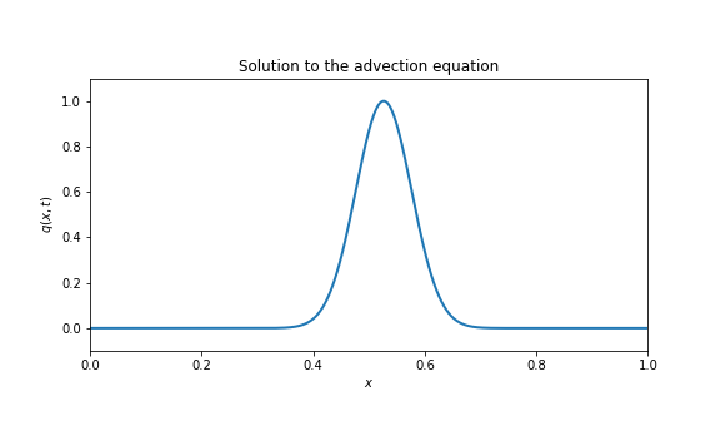
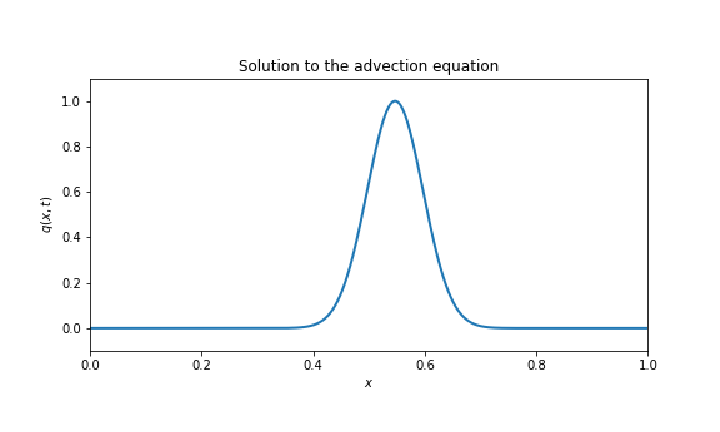
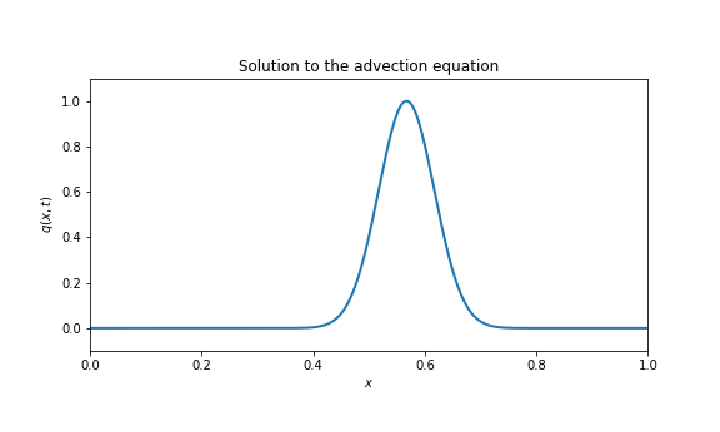
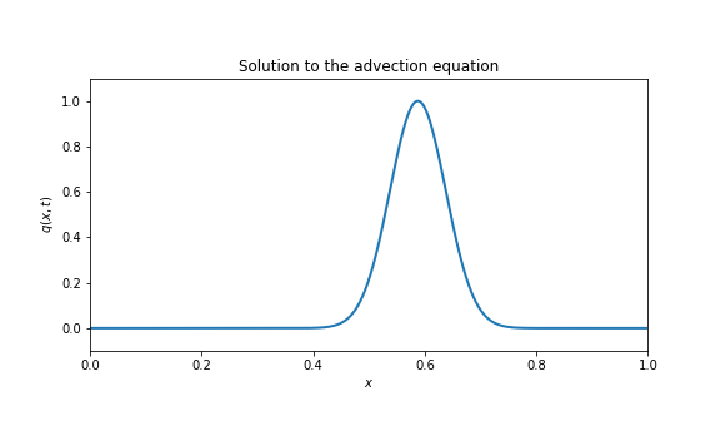
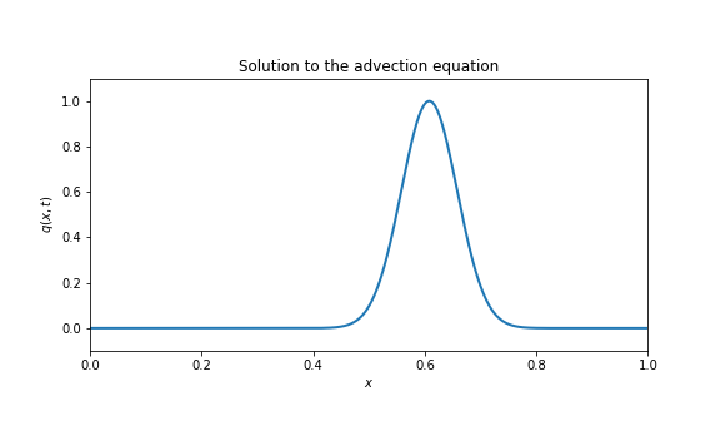
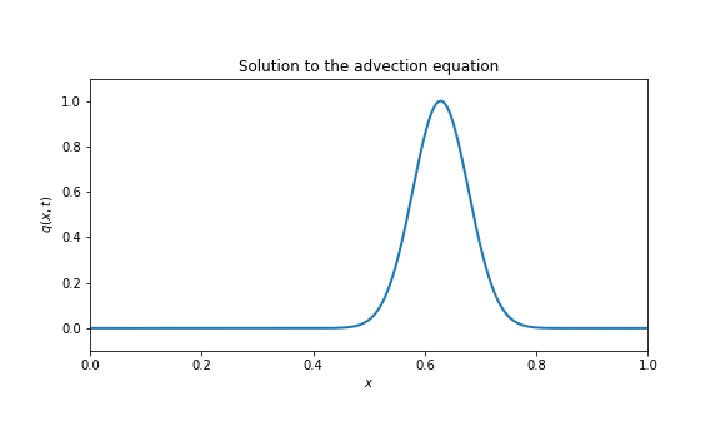
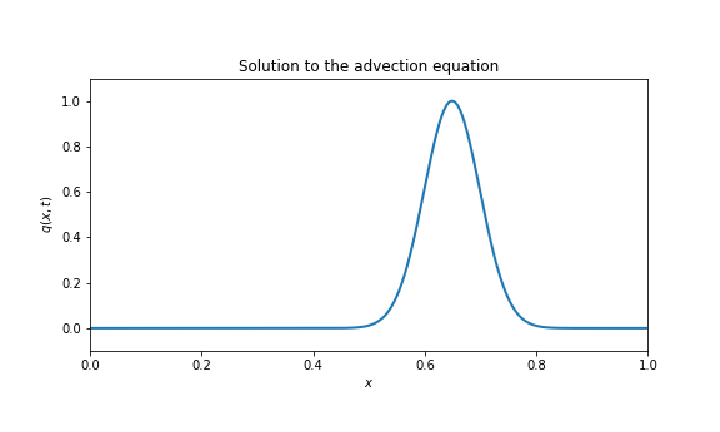
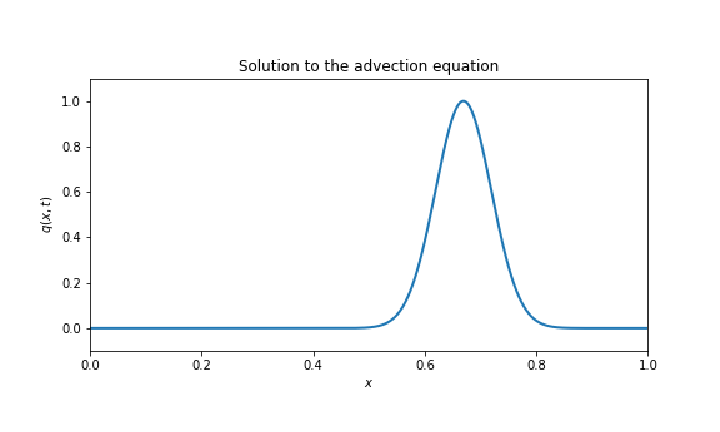
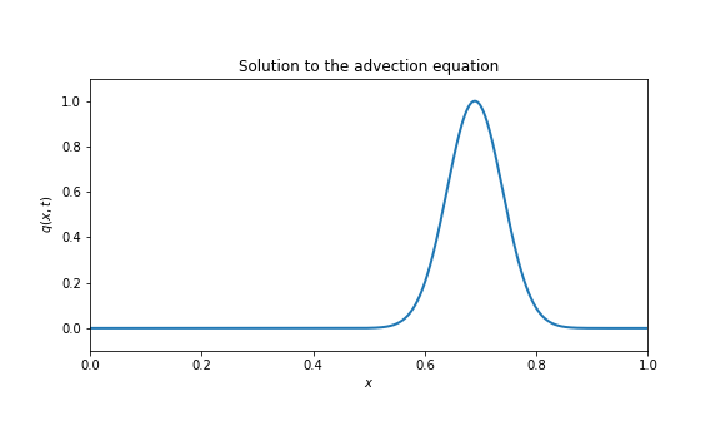
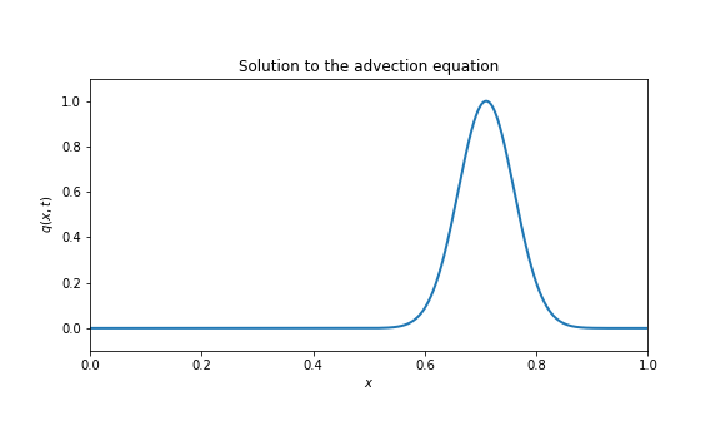
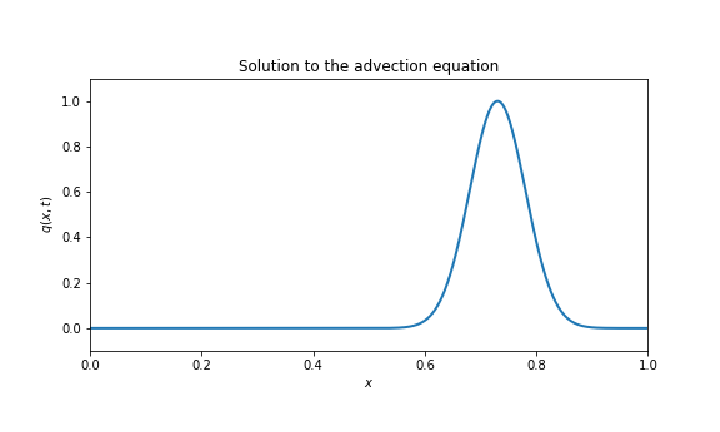
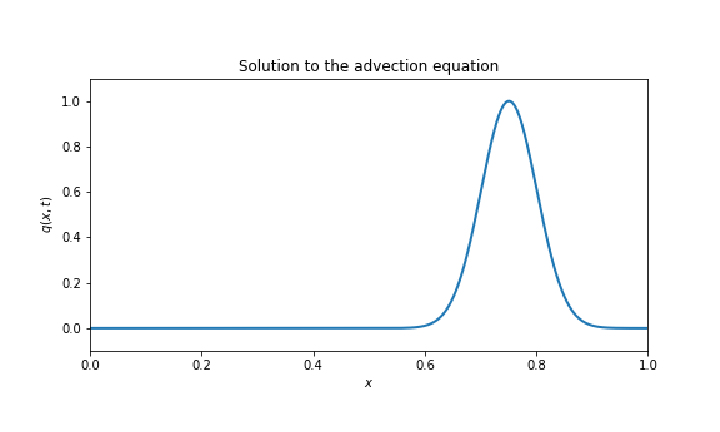
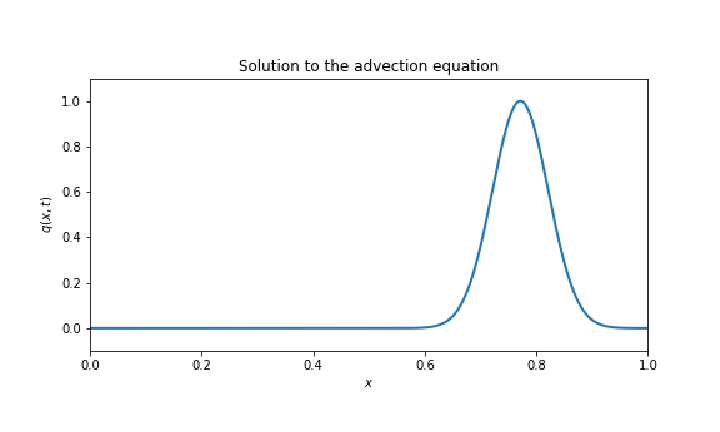
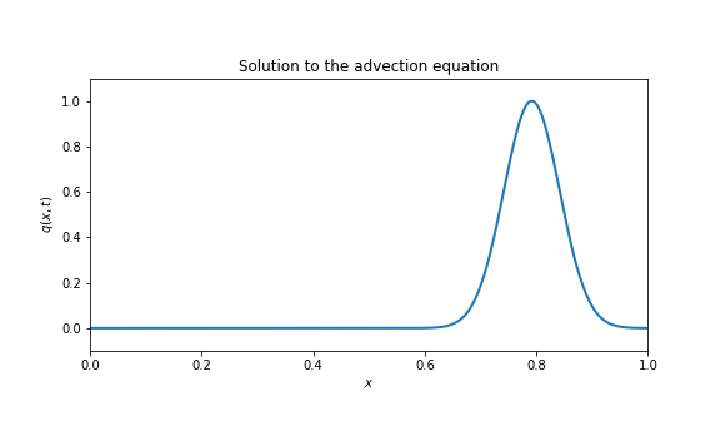
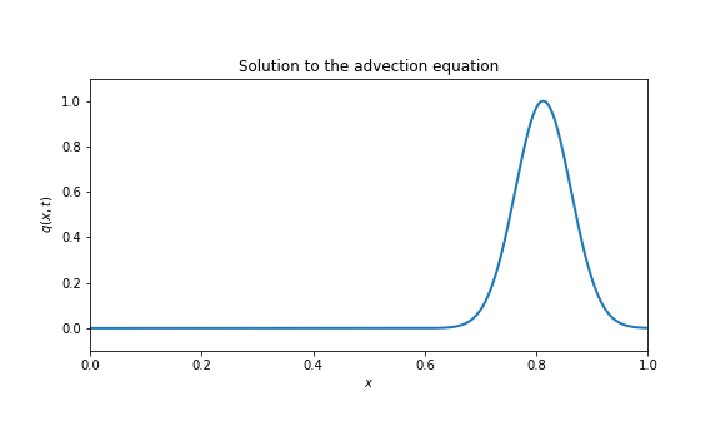
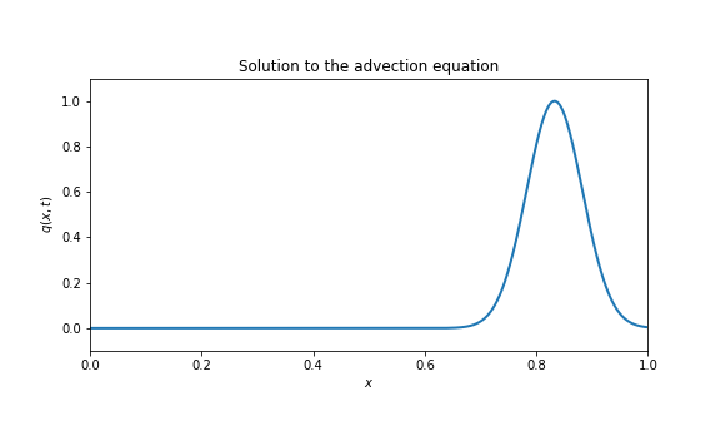
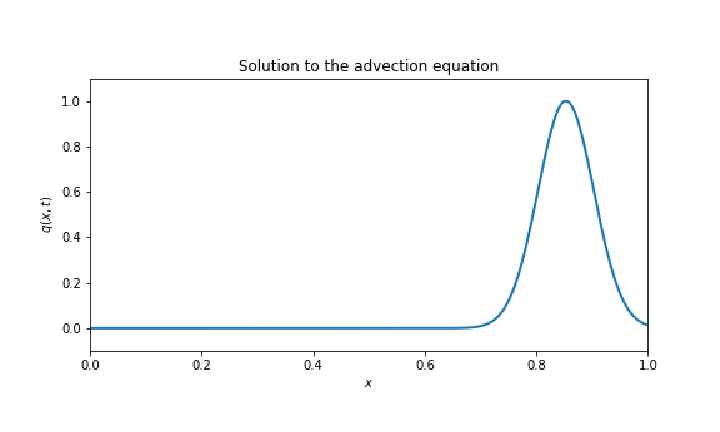
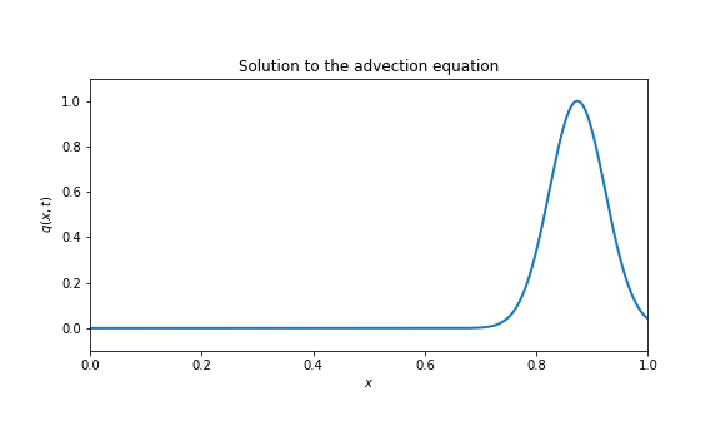
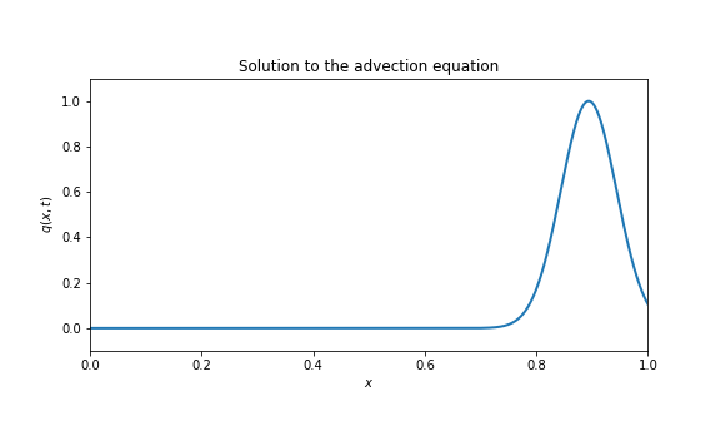
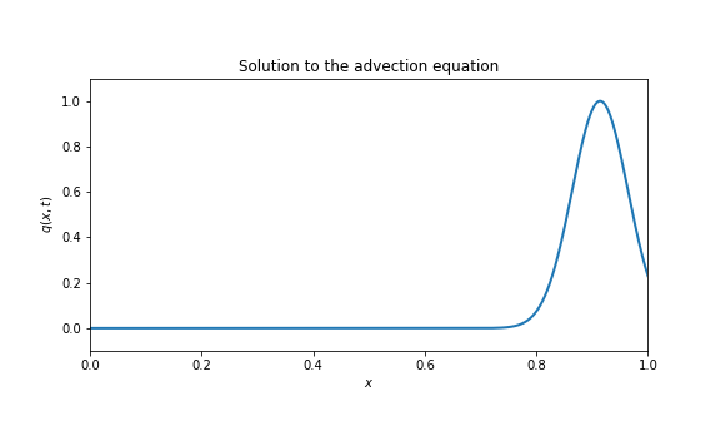
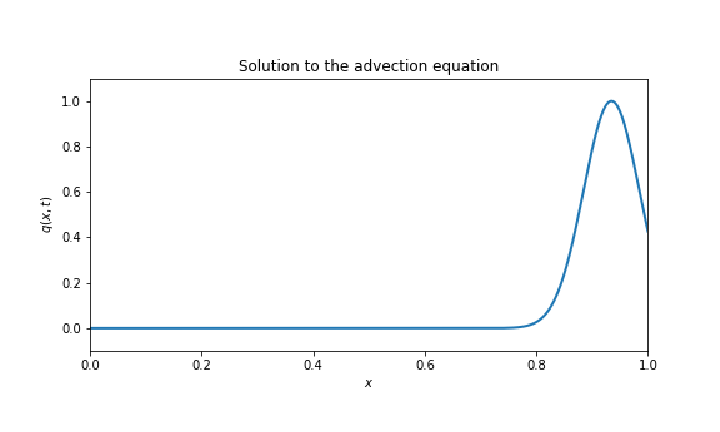
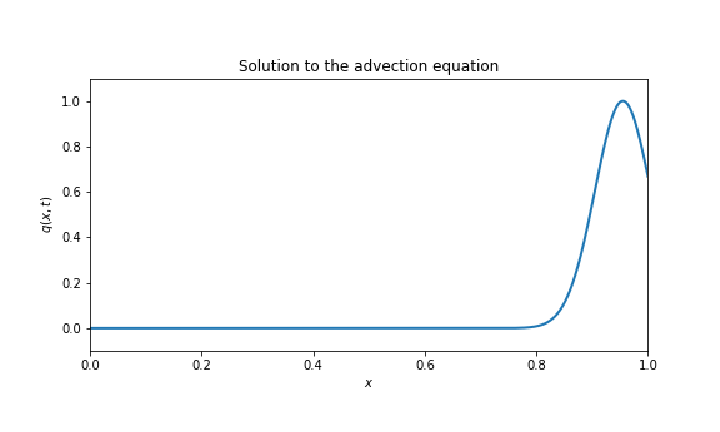
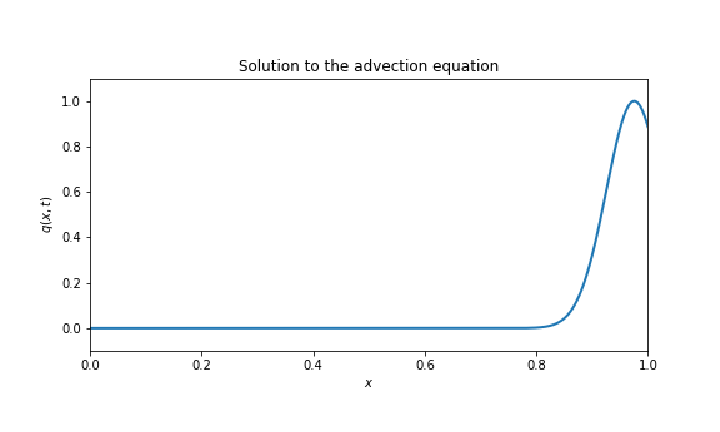
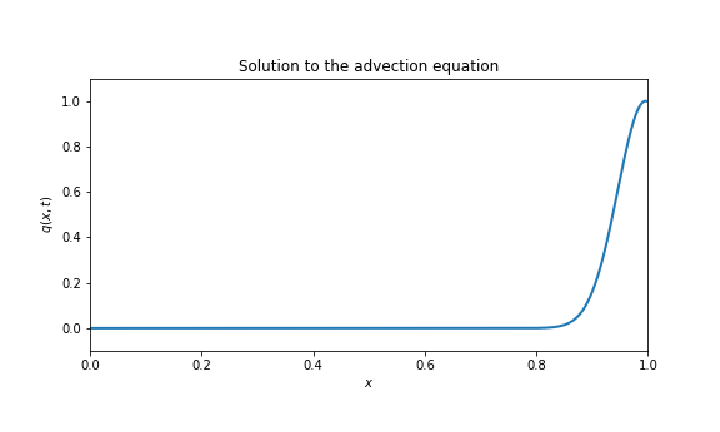
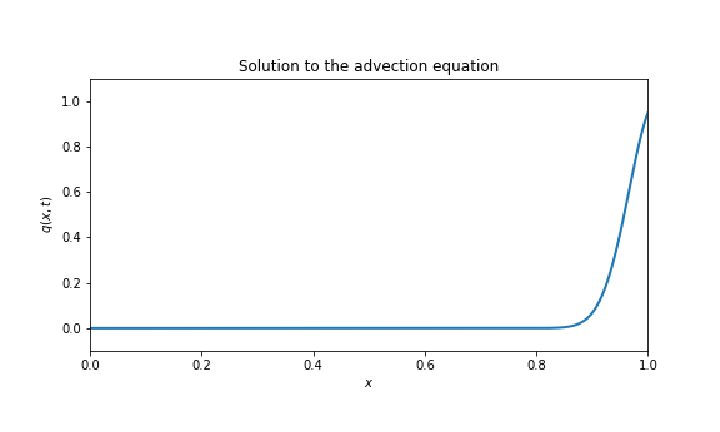
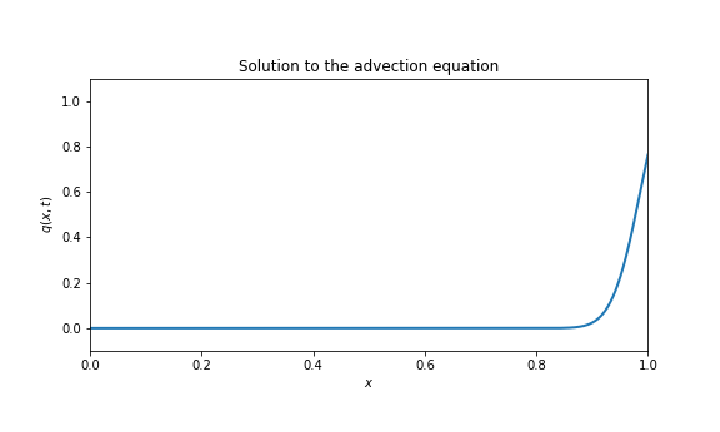
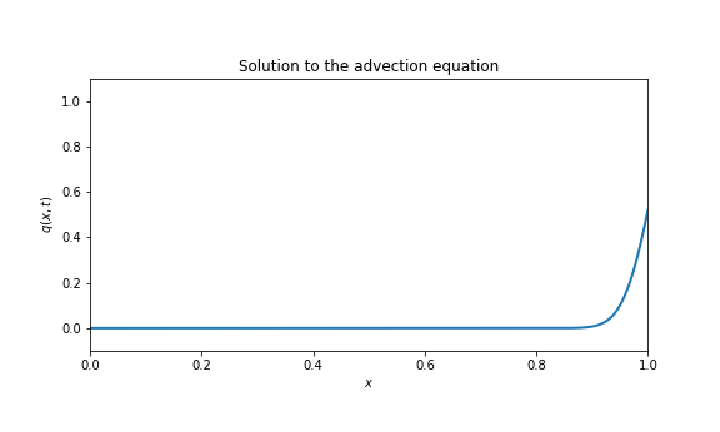
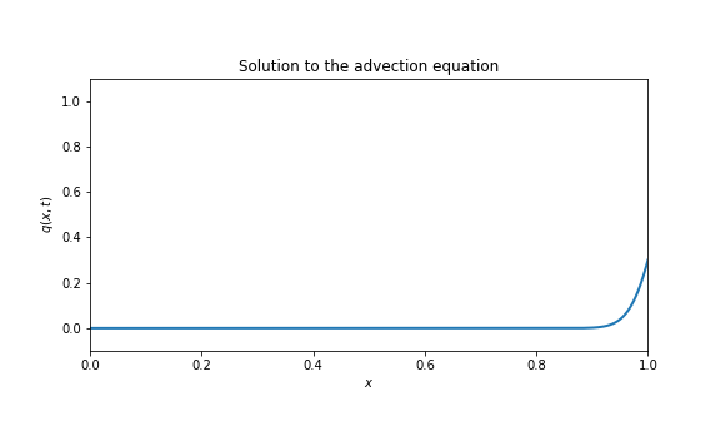
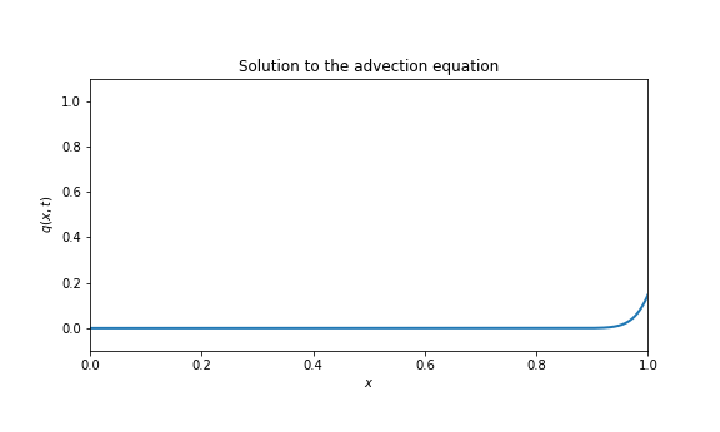
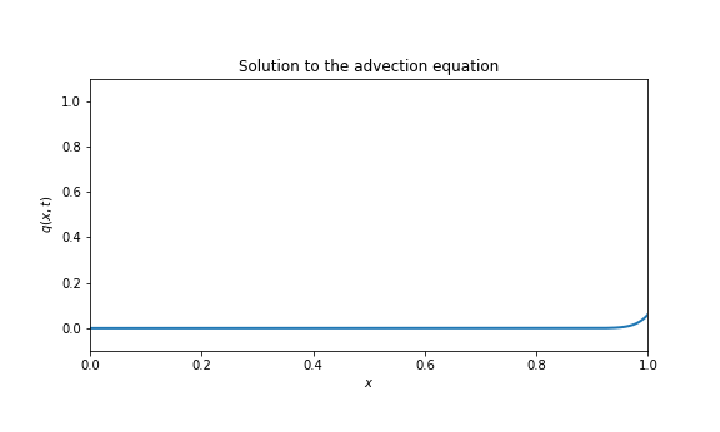
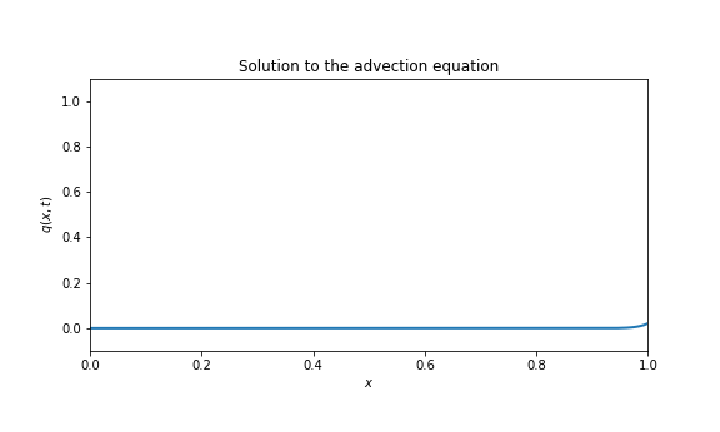
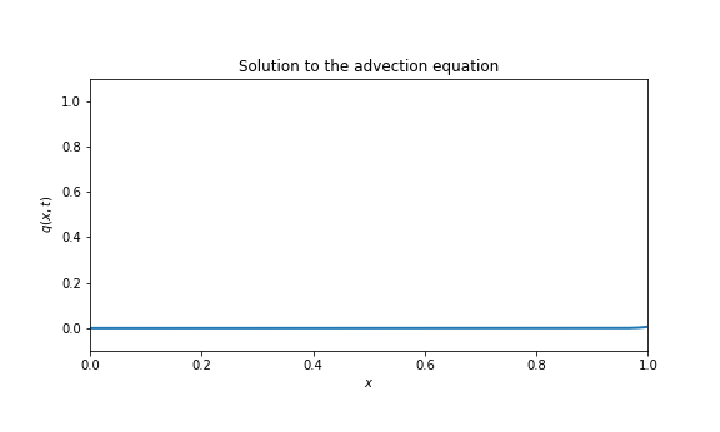
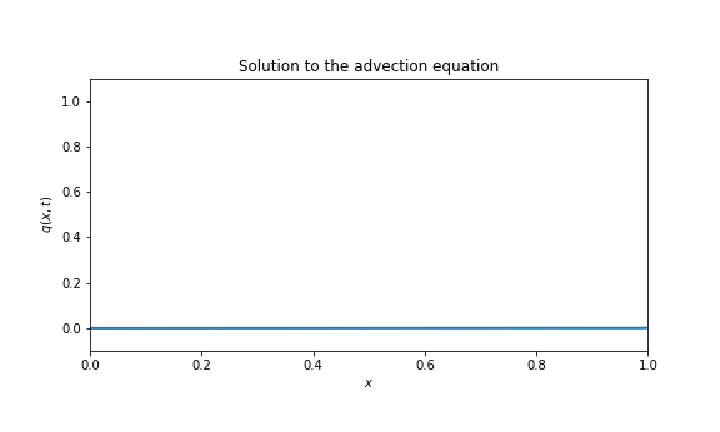
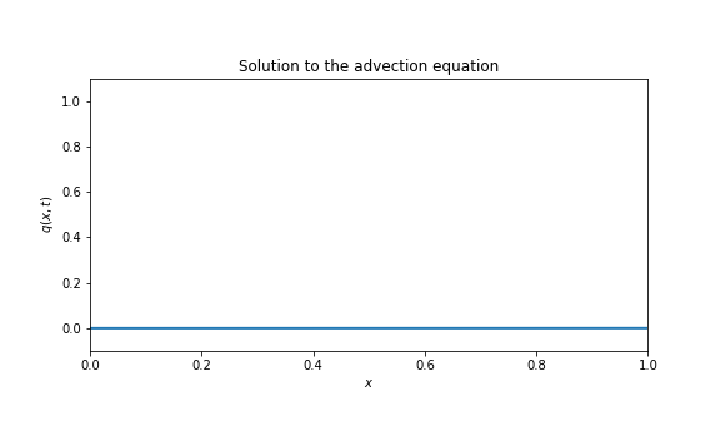

In [2]:
# Grid
x = numpy.linspace(0, 1, 1000) 

# Advection speed
a = 1.0                    

# Initial condition
def q_0(x):
    return numpy.exp(-200.*(x-0.2)**2)

figs = []
for t in numpy.linspace(0,1):
    figs.append(plt.figure(figsize=(8, 4)))
    axes = figs[-1].add_subplot(1, 1, 1)
    axes.plot(x, q_0(x - a * t), linewidth=2)
    axes.set_xlim((0, 1))
    axes.set_ylim((-0.1, 1.1))
    axes.set_xlabel("$x$")
    axes.set_ylabel("$q(x,t)$")
    axes.set_title("Solution to the advection equation")
    plt.close(figs[-1])
    
# Animate the solution
images = animation.make_images(figs)
animation.JSAnimate_images(images)

As you can see, the initial pulse just moves to the right at speed $a$ as time advances.  This isn't very interesting, but it captures the most important feature of hyperbolic equations: waves travel at finite speed.

## Discretization - Finite Differences

The general approach to deriving finite differences should be familiar for at least the first order differences.  Consider three different ways to define a derivative at a point $x_i$
$$
    u'(x_i) = \lim_{\Delta x \rightarrow 0} \left \{ \begin{aligned} 
        &\frac{u(x_i + \Delta x) - u(x_i)}{\Delta x} & \equiv D_+ u(x_i)\\
        &\frac{u(x_i + \Delta x) - u(x_i - \Delta_x)}{2 \Delta x} & \equiv D_0 u(x_i)\\
        &\frac{u(x_i) - u(x_i - \Delta_x)}{\Delta x} & \equiv D_- u(x_i).
    \end{aligned} \right .
$$

![Approximations to $u'(x)$](./images/fd_basic.png)

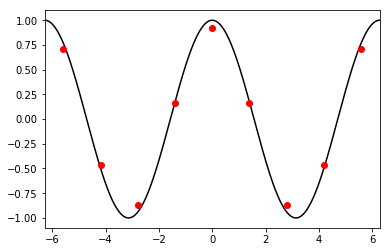

In [4]:
f = lambda x: numpy.sin(x)
f_prime = lambda x: numpy.cos(x)

# Use uniform discretization
x = numpy.linspace(-2 * numpy.pi, 2 * numpy.pi, 1000)
N = 10
x_hat = numpy.linspace(-2 * numpy.pi, 2 * numpy.pi, N)
delta_x = x_hat[1] - x_hat[0]

# Compute forward difference using a loop
f_prime_hat = numpy.empty(x_hat.shape)
for i in range(N - 1):
    f_prime_hat[i] = (f(x_hat[i+1]) - f(x_hat[i])) / delta_x
f_prime_hat[-1] = (f(x_hat[i]) - f(x_hat[i-1])) / delta_x

# Vector based calculation
# f_prime_hat[:-1] = (f(x_hat[1:]) - f(x_hat[:-1])) / (delta_x)

# Use first-order differences for points at edge of domain
f_prime_hat[-1] = (f(x_hat[-1]) - f(x_hat[-2])) / delta_x  # Backward Difference at x_N

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(x, f_prime(x), 'k')
axes.plot(x_hat + 0.5 * delta_x, f_prime_hat, 'ro')
axes.set_xlim((x[0], x[-1]))
axes.set_ylim((-1.1, 1.1))

plt.show()

### Finite Volume Method for Advection

We can easily solve the advection equation exactly.  But the advection equation is a prototype for more complicated conservation laws that we will only be able to solve approximately by using numerical methods.  In order to better understand these methods, we will discuss them first in the context of the advection equation.

For simplicity, we'll suppose that we wish to solve the advection equation on the interval $[0,1]$.  We introduce a set of equally spaced *grid cells* of width $\Delta x$, and write $x_i$ to mean the center of cell $i$.  Thus the first cell is the interval $[0,\Delta x]$ and $x_1=\Delta x/2$.  We will also write $x_{i-1/2}$ or $x_{i+1/2}$ to denote the left or right boundary of cell $i$, respectively.

We write $Q_i$ to denote the *average* value of the solution over cell $i$:

$$Q_i = \frac{1}{\Delta x} \int_{x_{i-1/2}}^{x_{i-1/2}} q \ dx.$$

The simplest finite volume method is obtained by supposing that the solution is actually *equal* to $Q_i$ over all of cell $i$.

![](./images/finite_volume.png)

Suppose $a>0$.  Then the flux into cell $i$ from the left is $a Q_{i-1}$ and the flux out of cell $i$ to the right is $a Q_i$.  Then our integral conservation law reads

$$Q_i'(t) = -\frac{a}{\Delta x}\left(Q_i - Q_{i-1}\right).$$

Applying a forward difference in time we obtain the *upwind method*
$$
    Q^{n+1}_i = Q^n_i -\frac{a \Delta t}{\Delta x}\left(Q_i - Q_{i-1}\right).
$$
This of course is also the same upwind method we derived when considering finite differences.

In [ ]:
a = 1.0

m = 100
delta_x = 1.0 / float(m)
x = numpy.arange(-delta_x / 2.0, 1.0 + delta_x / 2.0, delta_x)

t = 0.0
T = 0.5
CFL = 0.8
delta_t = CFL * delta_x / a

# Initial data
def q_0(x):
    return numpy.exp(-200.*(x-0.2)**2)
Q = q_0(x)
Q_new = Q.copy()

figs = []
while t < T:
    # Incoming wave
#     Q_new[0] = numpy.sin(20.0 * numpy.pi * t)
    # Extrapolation BCs
    Q_new[0] = Q_new[1]
    
    Q_new[1:] = Q[1:] - a * delta_t / delta_x * (Q[1:] - Q[:-1])
    
    Q = Q_new.copy()
    t = t + delta_t
    figs.append(plt.figure())
    axes = figs[-1].add_subplot(1, 1, 1)
    axes.plot(x, q_0(x - a * t), 'k', linewidth=2, label="True Solution")
    axes.plot(x, Q, 'o-', linewidth=2, label="Upwind")
    axes.set_title('t = %s' % str(t))
    axes.set_xlim((x[0], x[-1]))
    axes.set_ylim((-1.1, 1.1))
    axes.set_xlabel("$x$")
    axes.set_ylabel("$q(x,t)$")
    axes.set_title("Upwind Method")
    axes.legend(loc=4)
    plt.close(figs[-1])

# Animate the solution
images = animation.make_images(figs)
animation.JSAnimate_images(images)

We can see that we have picked a $\Delta t$ based on the CFL condition we derived for finite difference methods.  The same applies here (we are even using the same method).  

Notice how we set up a grid that contains an extra cell at each end, outside of the problem domain $[0,1]$.  These are called *ghost cells* and are often useful in handling the solution at the grid boundaries.

![](./images/ghost-cell.png)

The technique we have used to set the ghost cell values above, by copying the last value inside the grid to the ghost cells, is known as *zero-order extrapolation*.  It is useful for allowing waves to pass out of the domain (so-called *non-reflecting* boundaries).  Note that we don't actually need the ghost cell at the right end for the upwind method, but for other methods we will.

The upwind method is simple, but it is not very accurate.  Notice how the computed solution becomes wider and shorter over time.  This behavior is referred to as *dissipation*.

## Alternative Derivations

Another way to look view finite volume methods is more directly as a discretization of the PDE:
$$
    \frac{d}{dt} \int_{x_1}^{x_2} q(x,t) dx = f(q(x_1,t)) - f(q(x_2,t)).
$$
to
$$
    Q_i^{n+1} = Q^n_i - \frac{\Delta t}{\Delta x} \left [ F^n_{i+1/2} - F^n_{i-1/2} \right]
$$

![Stencil](./images/flux_stencil.png)

![Averaging view of advection](./images/ave_demo.png)

If the flux from the left of cell $i$ says that the value $Q^n_{i-1}$ moves in at a speed $\lambda$ then it will cover $\lambda \Delta t$ of the total call $i$'s length leaving $\Delta x - \lambda \Delta t$ the original value $Q^n_i$.  Averaging these two values to find $Q^{n+1}_{i}$ leads to

$$\begin{aligned}
    Q^{n+1}_i &= \frac{Q^n_i (\Delta x - \lambda \Delta t) + Q^n_{i-1} \lambda \Delta t}{\Delta x} \\
    &=Q^n_i - \frac{\lambda \Delta t}{\Delta x} [Q^n_i - Q^n_{i-1}],
\end{aligned}$$

exactly the up-wind method!

## Traffic Flow

As an illustrative example we will now consider a particular scalar conservation law, that of a simplified model for traffic flow.  This model is sometimes referred to as the Lighthill-Whitham-Richards (or LWR) traffic model.

From the continuity equation above we know:

$$q_t + (uq)_x = 0.$$

Now we will think of $q$ as the density of cars on a road, traveling with velocity $u$.  Note that we're not keeping track of the individual cars, but just of the average number of cars per unit length of road.  Thus $q=0$ represents an empty stretch of road, and we can choose the units so that $q=1$ represents bumper-to-bumper traffic.

We'll also choose units so that the speed limit is $u_\text{max}=1$, and assume that drivers never go faster than this (yeah, right!)  If we assume that drivers always travel at a single uniform velocity, we obtain once again the advection equation.  But we all know that's not accurate in practice -- cars go faster in light traffic and slower when there is congestion.  The simplest way to incorporate this effect is to make the velocity a linearly decreasing function of the density:

$$u(q) = 1 - q.$$

Notice that $u$ goes to zero as $q$ approaches the maximum density of 1, while $u$ goes to the maximum value of 1 as traffic density goes to zero.  Obviously, both $q$ and $u$ should always stay in the interval $[0,1]$.

![](./images/LWR-Velocity.png)

Combining the two equations above, our conservation law says

$$q_t + (q (1-q))_x = 0.$$

The function $q(1-q)$ is the flux, or the rate of flow of cars.  Notice how the flux is zero when there are no cars and also when the road is completely full.  The maximum flow of traffic actually occurs when the road is half full:

In [ ]:
q = numpy.linspace(0, 1)
f = q * (1.0 - q)
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(q,f,linewidth=2)
axes.set_xlabel('q')
axes.set_ylabel('$f(q)$')
axes.set_xlim((0, 1))
axes.set_ylim((0.0, 0.3))
plt.show()

This equation is fundamentally different from the advection equation because the flux is **nonlinear**.  This fact will have dramatic consequences for both the behavior of solutions and our numerical methods.  But we can superficially make this equation look like the advection equation by using the chain rule to write

$$f(q)_x = f'(q) q_x = (1-2q)q_x.$$

Then we have

$$q_t + (1-2q)q_x = 0.$$

This is like the advection equation, but with a velocity $1-2q$ that depends on the density of cars.  The value $f'(q)=1-2q$ is referred to as the *characteristic speed*.  This characteristic speed is not the speed at which cars move (notice that it can even be negative!)  Rather, it is the speed at which *information* is transmitted along the road.

### Shock waves (traffic jams)

Let's use the *Lax-Friedrichs method* to solve the LWR traffic model.

In [ ]:
m = 100
delta_x = 1.0 / m
x = numpy.arange(-delta_x / 2.0, 1.0 + delta_x / 2.0, delta_x)

t = 0.0
T = 0.5
CFL = 0.9
delta_t = CFL * delta_x

Q = 0.9 * numpy.exp(-100.0 * (x - 0.5)**2)
Q_new = numpy.empty(Q.shape)
Q_list = [Q]

figs = []
while t < T:
    
    Q_new[1:-1] = 0.5 * (Q[:-2] + Q[2:]) - 0.5 * delta_t / delta_x \
                                               * (Q[2:] * (1.0 - Q[2:]) - Q[:-2] * (1.0 - Q[:-2]))
    
    Q = Q_new.copy()
    Q[0] = Q[-2]
    Q[-1] = Q[1]
    t += delta_t
    
    figs.append(plt.figure())
    axes = figs[-1].add_subplot(1, 1, 1)
    axes.plot(x, Q, 'o-', linewidth=2)
    axes.set_title('Lax-Friedrichs Method - Traffic Flow at t = %s' % str(t))
    axes.set_xlabel("$x$")
    axes.set_ylabel("$q(x,t)$")
    axes.set_xlim((x[0], x[-1]))
    axes.set_ylim((-0.1, 1.1))
    plt.close(figs[-1])
    
# Animate the solution
images = animation.make_images(figs)
animation.JSAnimate_images(images)

Starting from an initially smooth distribution of cars, we see that the solution evolves into something discontinuous!  What's going on?

Naturally, the cars in the low-density region behind the peak initially drive faster than the cars in the most congested region, ahead of them.  This leads to a steepening of the rear part of the traffic flow, and eventually there is a traffic jam: cars coming from the back have an open road, until suddenly they reach a highly congested area and must slam on the brakes.  Sound familiar?

#### Exercises

1. Recall our discussion of the CFL condition for advection.  To apply the CFL condition to a nonlinear problem, we use the characteristic velocity (in this case $1-2q$) in place of the velocity $a$.  For this problem, how large can we take the time step without violating the CFL condition? 

1. In the cell below, set things up to find out what happens when cars reach a red light.  Place the red light at $x=1$ and set $q=1$ in the interval $0.8<x<1$ near the light (the cars will be stopped, bumper to bumper there).  In the rest of the domain, set $q=0.2$, corresponding to light traffic.  In the ghost cell at the right boundary, set $q=1$; in the ghost cell at the left set $q=0.2$.  After you have computed the solution, check it against your inuition.  Does it make sense?

## High-Resolution Methods

The methods we have used so far (the *upwind method* and the *Lax-Friedrichs method*) are both dissipative.  This means that over time they artificially smear out the solution -- especially shocks.  Furthermore, both of these methods are only *first order accurate*, meaning that if we reduce the values of $\Delta t$ and $\Delta x$ by a factor of two, the overall error decreases (only) by a factor of two.  We can do better.

### Reducing Diffusion (Dissipation)

The first step in improving our accuracy is to use a more accurate representation of $q(x)$ at each step.  Instead of assuming that $q$ is piecewise-constant, we will now approximate it by a piecewise-linear function:

$$q(x) = Q^n_i + \sigma^n_i (x-x_i).$$

Here $\sigma_i$ represents the slope in cell $i$.  The most obvious choice to ensure that this results in a second-order accurate approximation is to take the centered approximation

$$\sigma^n_i = \frac{Q^n_{i+1} - Q^n_{i-1}}{2\Delta x}.$$

We use this to obtain values at the cell interfaces:

$$\begin{aligned}
q^+_{i - 1/2} & = Q_i - \sigma_i \frac{\Delta x}{2} \\
q^-_{i + 1/2} & = Q_i + \sigma_i \frac{\Delta x}{2}.
\end{aligned}$$

![](./images/linear_reconstruction.png)

We'll use these interface values to approximate the flux, based on the *Lax-Friedrichs flux* (related to the Lax-Friedrichs method):

$$F_{i - 1/2} = \frac{1}{2} \left( f(q^-_{i - 1/2}) + f(q^+_{i - 1/2}) - \frac{\Delta t}{\Delta x} (q^+_{i - 1/2} - q^-_{i - 1/2})\right)$$

This provides second-order accuracy in space.  We also need to make the method second-order accurate in time.  We can do so by using a second-order Runge--Kutta method.  Then the full method is

$$\begin{aligned}
Q^*_i & = Q^n_i - \frac{\Delta t}{\Delta x}\left( F^n_{i - 1/2} - F^n_{i - 1/2} \right) \\
Q^{n+1}_i & = \frac{1}{2} Q^n_i + \frac{1}{2}\left( Q^*_i - \frac{\Delta t}{\Delta x}\left( F^*_{i + 1/2} - F^*_{i - 1/2} \right) \right) \\
\end{aligned}$$

In [ ]:
def f(q):
    return q * (1.0 - q)

m = 100
delta_x = 1.0 / float(m)
x = numpy.arange(-3.0 * delta_x / 2.0, 1.0 + 5.0 * delta_x / 2.0, delta_x)

t = 0. # Initial time
T = 0.5 # Final time
CFL = 0.9
delta_t = CFL * delta_x  # Time step

Q_HR = 0.9 * numpy.exp(-100.0 * (x - 0.5)**2)
Q_new_HR = numpy.zeros(m + 4)
Q_star = numpy.zeros(m + 4)
sigma = numpy.zeros(m + 4)
F = numpy.zeros(m + 4)

Q_LF = 0.9 * numpy.exp(-100.0 * (x - 0.5)**2)
Q_new_LF = numpy.zeros(m + 4)

figs = []
while t < T:
    
    # High-resolution version
    sigma[1:-1]  = (Q_HR[2:] - Q_HR[:-2]) / (2.0 * delta_x)
    q_plus  = Q_HR[1:-1] - sigma[1:-1] * delta_x / 2.0
    q_minus = Q_HR[:-2] + sigma[:-2]  * delta_x / 2.0
    F[1:-1] = 0.5 * (f(q_plus) + f(q_minus) - delta_x / delta_t * (q_plus - q_minus) )
    
    Q_star[2:-2] = Q_HR[2:-2] - delta_t / delta_x * (F[3:-1] - F[2:-2])
    Q_star[0:2] = Q_star[2]
    Q_star[-2:] = Q_star[-3]
    
    sigma[1:-1]  = (Q_star[2:] - Q_star[:-2]) / (2.0 * delta_x)
    q_plus  = Q_star[1:-1] - sigma[1:-1] * delta_x / 2.0
    q_minus = Q_star[:-2] + sigma[:-2]  * delta_x / 2.0
    F[1:-1] = 0.5 * (f(q_plus) + f(q_minus) - delta_x / delta_t * (q_plus - q_minus))
    
    Q_new_HR[2:-2] = 0.5 * Q_HR[2:-2] + 0.5 * (Q_star[2:-2] - delta_t / delta_x * (F[3:-1] - F[2:-2]))
        
    Q_HR = Q_new_HR.copy()
    Q_HR[0:2] = Q_HR[2]
    Q_HR[-2:] = Q_HR[-3]
    t += delta_t
    
    # LF Version
    Q_new_LF[1:-1] = 0.5 * (Q_LF[:-2] + Q_LF[2:]) - 0.5 * delta_t / delta_x * (Q_LF[2:] *(1.0 - Q_LF[2:]) - Q_LF[:-2] * (1.0 - Q_LF[:-2]))
    
    Q_LF = Q_new_LF.copy()
    Q_LF[0] = Q_LF[-2]
    Q_LF[-1] = Q_LF[1]
    t += delta_t
    
    figs.append(plt.figure())
    axes = figs[-1].add_subplot(1, 1, 1)
    axes.plot(x, Q_HR, 'o-', linewidth=2, label="High Resolution")
    axes.plot(x, Q_LF, 'x', linewidth=2, label="Original")
    axes.set_title('t = %s' % str(t))
    axes.set_xlim((x[0], x[-1]))
    axes.set_ylim((-0.1, 1.1))
    axes.legend()
    plt.close(figs[-1])
    
# Animate the solution
images = animation.make_images(figs)
animation.JSAnimate_images(images)

The shock wave is much sharper now, but we have a new problem. Do you see the little dip behind the shock?  If you look closely, you'll see that the solution is actually negative there!  Obviously, a negative density of cars makes no sense.  What's more, the solution shouldn't dip there -- and it shouldn't have that funny bump just in front of the shock either.  What to do?

### Slope Limiting

The spurious oscillations in our solution are not a particular feature of the method we've chosen.  In fact, *any* second-order (or higher) method that computes $q^\pm_{i + 1/2}$ as a linear function of the cell averages will have oscillations (this is a famous result known as *Godunov's Theorem*).

We can get around this difficulty by choosing the slope $\sigma$ as a *nonlinear* function of the cell averages.  In particular, to avoid oscillations we can choose the smaller of the two one-sided slopes.  Let $\Delta Q_{i - \Delta x} = Q_i - Q_{i-1}$.  Then we use the slope

$$\begin{aligned}
\sigma_i & = \text{minmod}(\Delta Q_{i-1/2},\Delta Q_{i + 1/2})/\Delta x \\
& = \begin{cases} \min(\Delta Q_{i-1/2}, \Delta Q_{i + 1/2})/\Delta x & \text{ if } \Delta Q_{i-1/2}, \Delta Q_{i + 1/2} > 0 \\
\max(\Delta Q_{i - 1/2}, \Delta Q_{i + 1/2})/\Delta x & \text{ if } \Delta Q_{i-1/2}, \Delta Q_{i + 1/2} < 0 \\
0 & \text{ if } \Delta Q_{i-1/2}\cdot \Delta Q_{i + 1/2} < 0.
\end{cases}
\end{aligned}$$

This choice of slope is known as the minimum-modulus, or *minmod* slope.

### Local Lax-Friedrichs flux

The Lax-Friedrichs flux ensures that our solution is stable, but it does so by adding a lot of dissipation everywhere.  In fact, we could get away with using less dissipation over most of the domain.  A variant that does this is called the *local Lax-Friedrichs flux*.  It is little more accurate than the Lax-Friedrichs flux because it uses the local characteristic speeds to determine how much dissipation is needed at each interface.  It is

$$F_{i - \Delta x} = \frac{1}{2} \left( f(q^-_{i - 1/2}) + f(q^+_{i - 1/2}) - \alpha_{i - 1/2}\frac{\Delta x}{\Delta t} (q^+_{i - 1/2} - q^-_{i - 1/2})\right)$$

where

$$\alpha_{i - 1/2} = \min(\left|f'(q^-_{i - 1/2})\right|,\left|f'(q^+_{i - 1/2})\right|).$$

#### Exercise

In the cell below, copy and modify the second-order method above to use the minmod slope and local Lax-Friedrichs flux.  

*Hint 1*: You will want to use the functions `numpy.minimum` and `numpy.maximum`, which compare two arrays elementwise (not `numpy.min`, which finds the minimum of a single array).

*Hint 2*: to avoid using a loop for the slope computation, note that the minmod function can be written as
$$
\text{minmod}(a,b) = \frac{\text{sign}(a)+\text{sign}(b)}{2} \min(|a|,|b|).
$$
The signum function is implemented as `numpy.sign()`. 

In [ ]:
def minmod(a, b):
    return (numpy.sign(a) + numpy.sign(b)) / 2.0 * numpy.minimum(numpy.abs(a), numpy.abs(b))

def f(q):
    return q * (1.0 - q)

def f_prime(q):
    return 1.0 - 2.0 * q

m = 100
delta_x = 1.0 / float(m)
x = numpy.arange(-3.0 * delta_x / 2.0, 1.0 + 5.0 * delta_x / 2.0, delta_x)

t = 0. # Initial time
T = 0.5 # Final time
# T = delta_t * 20
CFL = 0.9
delta_t = CFL * delta_x  # Time step

Q = 0.9 * numpy.exp(-100.0 * (x - 0.5)**2)
Q_new = numpy.zeros(m + 4)
Q_star = numpy.zeros(m + 4)
sigma = numpy.zeros(m + 4)
F = numpy.zeros(m + 4)

Q_LF = 0.9 * numpy.exp(-100.0 * (x - 0.5)**2)
Q_new_LF = numpy.zeros(m + 4)

figs = []
while t < T:
    
    sigma[1:-1]  = minmod(Q[1:-1] - Q[:-2], Q[2:] - Q[1:-1]) / delta_x
    Q_plus  = Q[1:-1] - sigma[1:-1] * delta_x / 2.0
    Q_minus = Q[:-2] + sigma[:-2]  * delta_x / 2.0
    alpha = numpy.minimum(numpy.abs(f_prime(Q_minus)), numpy.abs(f_prime(Q_plus)))
    F[1:-1] = 0.5 * (f(Q_plus) + f(Q_minus) - alpha * delta_x / delta_t * (Q_plus - Q_minus) )
    
    Q_star[2:-2] = Q[2:-2] - delta_t / delta_x * (F[3:-1] - F[2:-2])
    Q_star[0:2] = Q_star[2]
    Q_star[-2:] = Q_star[-3]
    
    sigma[1:-1]  = (Q_star[2:] - Q_star[:-2]) / (2.0 * delta_x)
    q_plus  = Q_star[1:-1] - sigma[1:-1] * delta_x / 2.0
    q_minus = Q_star[:-2] + sigma[:-2]  * delta_x / 2.0
    F[1:-1] = 0.5 * (f(Q_plus) + f(Q_minus) - delta_x / delta_t * (Q_plus - Q_minus))
    
    Q_new[2:-2] = 0.5 * Q[2:-2] + 0.5 * (Q_star[2:-2] - delta_t / delta_x * (F[3:-1] - F[2:-2]))
        
    Q = Q_new.copy()
    Q[0:2] = Q[2]
    Q[-2:] = Q[-3]
    t += delta_t
        
    # LF Version
    Q_new_LF[1:-1] = 0.5 * (Q_LF[:-2] + Q_LF[2:]) - 0.5 * delta_t / delta_x * (Q_LF[2:] *(1.0 - Q_LF[2:]) - Q_LF[:-2] * (1.0 - Q_LF[:-2]))
    
    Q_LF = Q_new_LF.copy()
    Q_LF[0] = Q_LF[-2]
    Q_LF[-1] = Q_LF[1]
    t += delta_t
    
    figs.append(plt.figure())
    axes = figs[-1].add_subplot(1, 1, 1)
    axes.plot(x, Q, 'o-', linewidth=2, label="High Resolution")
    axes.plot(x, Q_LF, 'x', linewidth=2, label="Original")
    axes.set_title('t = %s' % str(t))
    axes.set_xlim((x[0], x[-1]))
    axes.set_ylim((-0.1, 1.1))
    axes.legend()
    plt.close(figs[-1])
    
# Animate the solution
images = animation.make_images(figs)
animation.JSAnimate_images(images)

As you can see, this method keeps the shock fairly sharp and avoids the creation of negative solution values.  This method falls into the class of [MUSCL]() schemes and is proven to avoid oscillations.

### High-Order Methods

Just like the method we implemented above, most methods that are more than first-order accurate consist of three components:
1. **Reconstruction**: A method for computing interface values $q^\pm_{i - \Delta x}$ from cell averages $Q_i$.  This involves some kind of limiting in order to avoid oscillations.  Higher-order reconstruction is often done using [weighted essentially non-oscillatory (WENO)](http://www.dam.brown.edu/scicomp/media/report_files/BrownSC-2006-21.ps.gz) methods.
2. **Numerical flux**:  An approximation of the flux, computed based on the interface values $q^\pm_{i - \Delta x}$.  The Lax-Friedrichs flux above is one of the simplest.  Much more accurate fluxes can be computed using an exact or approximate [Riemann solver](http://en.wikipedia.org/wiki/Riemann_solver).
3. **Time integrator**: In order to get high-order accuracy in time, usually a [Runge-Kutta method](http://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) is used.  [Strong stability preserving methods](http://www.davidketcheson.info/assets/papers/sspreview.pdf) are particularly popular.

It's possible to devise methods of very high order by increasing the order of the polynomial reconstruction and of the time integrator.

![Reconstruction](./images/reconstruction_1.png)

![Reconstruction-constants](./images/reconstruction_2.png)

![Reconstruction-linear](./images/reconstruction_3.png)

![Reconstruction-quadratic](./images/reconstruction_4.png)

There are many different ways to reconstruct and limit solutions, try out a few.  This requires a Clawpack installation, see the [Clawpack webpage](http://www.clawpack.org) for installation instructions.

In [ ]:
# Demo limiters
from clawpack import pyclaw
from clawpack import riemann

# Pick out Riemann solver
riemann_solver = riemann.advection_1D_py.advection_1D

# Create solver
solver = pyclaw.ClawSolver1D(riemann_solver)
solver.kernel_language = "Python"
solver.bc_lower[0] = pyclaw.BC.periodic
solver.bc_upper[0] = pyclaw.BC.periodic

# Limiters avaiable
solver.limiters = -2
# To pick a Godunov upwind method set order to 1
solver.order = 2
limiter_name = ["None", "minmod", "superbee", "Van Leer", "MC", "Beam-Warming", "Fromm",
                "Albada 2", "Albada 3", "Van Leer with Klein sharpening"]

# Set up domain
x = pyclaw.Dimension(0.0, 1.0, 100, name='x')
domain = pyclaw.Domain(x)
state = pyclaw.State(domain, solver.num_eqn)

# Problem specific data
state.problem_data['u'] = 1.0

# Initial condition
xc = state.grid.x.centers
beta = 100; gamma = 0; x0 = 0.75
state.q[0, :] = numpy.exp(-beta * (xc-x0)**2) * numpy.cos(gamma * (xc - x0))
state.q[0, :] += 1.0 * (0.2 < xc) * (xc < 0.4)

# Set up time stepping and other run parameters
claw = pyclaw.Controller()
claw.keep_copy = True
claw.solution = pyclaw.Solution(state, domain)
claw.solver = solver
claw.num_output_times = 30
claw.tfinal = 30.0

claw.run()

figs = []
for frame in claw.frames:
    figs.append(plt.figure())
    axes = figs[-1].add_subplot(1, 1, 1)
    axes.plot(xc, frame.q[0, :], 'o-', linewidth=2)
    axes.plot(xc, claw.frames[0].q[0, :], 'k--')
    axes.set_xlim((0, 1))
    axes.set_ylim((-0.2, 1.2))
    axes.set_title("Limiter = %s" % limiter_name[solver.limiters])
    plt.close(figs[-1])
    
# Animate the solution
images = animation.make_images(figs)
animation.JSAnimate_images(images)